In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [3]:
from tqdm.notebook import tqdm

  0%|          | 0/5 [00:00<?, ?it/s]

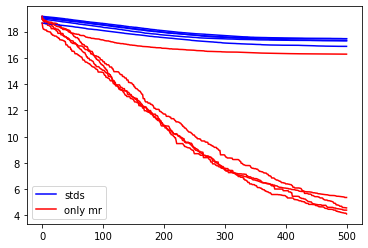

In [77]:
def run_evolution_dir(pop, optim_fn, n_gen, n_mutpop=10, mr=None, mr_mut=2., 
                       k=.5, k_elite=None,
                       tqdm=lambda x: x, debug=False):
    mr_means = torch.zeros(n_mutpop, pop.shape[-1], device=pop.device)
    mr_stds = torch.logspace(-2, -2, n_mutpop)
    mr_stds = mr_stds[:, None].repeat(1, pop.shape[-1])
#     mr_stds = mr_stds[:, None]
    
    data = []
    mrpop2mr = np.arange(len(pop)-1)//int(len(pop)/len(mr_means))
    fit = optim_fn(pop)
    for i in tqdm(range(n_gen)):
#         print('------------------------------')
#         print(f'Generation {i}')
        bpop = pop
        bfit = fit
        
        idxs_elite, idxs_rest, idxs_cat = optim.calc_npop_idxs(fit, k=k, k_elite=k_elite)
#         pop = optim.calc_npop_gaussian(pop, mutpop[mrpop2mr], idxs_elite, idxs_rest, idxs_cat)
        m = mr_means[mrpop2mr]
        s = mr_stds[mrpop2mr]
        pop = optim.calc_npop_gaussian_mean_std(pop, m, s,
                                                idxs_elite, idxs_rest, idxs_cat)
        fit = optim_fn(pop)
        fit_mrs = (fit[1:]-bfit[idxs_rest]).reshape(len(mr_means), -1)
        data.append((bpop, bfit, mr_means, mr_stds, fit_mrs))
        fit_mrs_min = fit_mrs.min(dim=-1).values
        
        mr_stds_mean = mr_stds.log().mean(dim=-1).exp()
        mr_rank = mr_stds_mean.argsort()
        if debug:
            print(fit_mrs.shape)
            if i%10==0:
                plt.plot(fit_mrs.min(dim=-1).values[mr_rank], mr_stds_mean[mr_rank], c='r', linewidth=1)
                for i in range(10):
                    plt.scatter(fit_mrs[:, i], mr_stds_mean, c='b', s=5)
                plt.yscale('log')
                plt.show()
    #         for i in range(n_mutpop):
    #             print(f'Average STD: {mr_stds.log().mean(dim=-1).exp()[i].item():.2e}')
    #             for fit_mr_i in fit_mrs[i]:
    #                 print(f'\t {fit_mr_i}')
        
        mr_idxs_sel = optim.calc_npop_idxs(fit_mrs_min, k=.9)
        mr_stds = optim.calc_npop_log_uniform(mr_stds, mr_mut, *mr_idxs_sel)
#         mr_means = optim.calc_npop_gaussian(mr_means, 1e-2, *mr_idxs_sel)
    data.append((pop, fit, mr_means, mr_stds, fit_mrs))
        
    # pops, fits, mrs, fitmrs
    return [torch.stack([d[i] for d in data]) for i in range(len(data[0]))]


for seed in tqdm(range(5)):
    do_seed(seed)
    n_gen = 500
    # pop = torch.randn(101, 100)*10
    pop = 10*torch.randn(1, 100).repeat(101, 1)
    optim_fn = ackley
    pops_dir, fits_dir, mr_means, mr_stds, _ = run_evolution_dir(pop, optim_fn, n_gen, mr_mut=1.01)
    plt.plot(fits_dir.min(dim=-1).values, c='blue', label='stds' if seed==0 else None)
    pops, fits, mrs, _ = optim.run_evolution_ours(pop, optim_fn, n_gen)
    plt.plot(fits.min(dim=-1).values, c='red', label='only mr' if seed==0 else None)
    plt.legend()

In [78]:
mr_stds.shape, mrs.shape

(torch.Size([501, 10, 100]), torch.Size([501, 10, 1]))

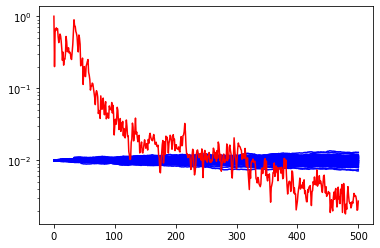

In [79]:
plt.plot(mr_stds.log().mean(dim=-2).exp(), c='b', label='stds');
plt.plot(mrs.log().mean(dim=-2).exp(), c='r', label='only mr')
plt.yscale('log')

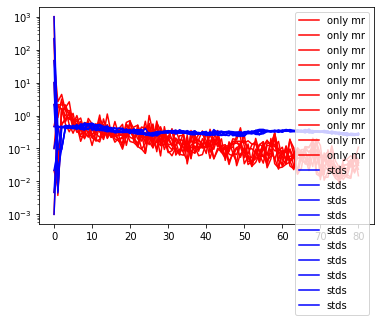

In [33]:
plt.plot(mrs[:, :, 0],c='r', label='only mr');
plt.plot(mr_stds.log().mean(dim=-1).exp(), c='b', label='stds');
plt.yscale('log')
plt.legend()

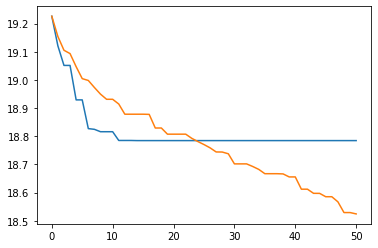

In [428]:
do_seed(5)
n_gen = 50
# pop = torch.randn(101, 100)*10
pop = 10*torch.randn(1, 100).repeat(101, 1)
optim_fn = ackley
pops_dir, fits_dir, mr_means, mr_stds, _ = run_evolution_dir(pop, optim_fn, n_gen)
plt.plot(fits_dir.min(dim=-1).values)
pops, fits, mrs, _ = optim.run_evolution_ours(pop, optim_fn, n_gen, )
plt.plot(fits.min(dim=-1).values)


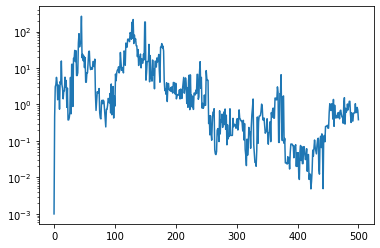

In [376]:
plt.plot(mr_stds[:, 0, 0])
plt.yscale('log')

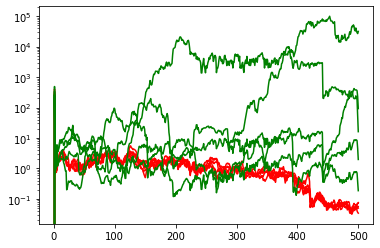

In [362]:
# pops.mean(dim=-2).shape
plt.plot(pops.std(dim=-2)[:, ::20], c='r')
plt.plot(pops_dir.std(dim=-2)[:, ::20], c='g')
plt.yscale('log')

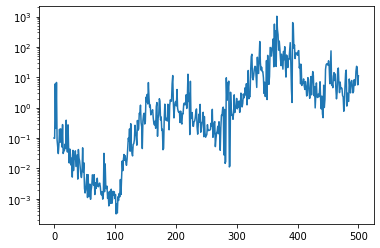

In [340]:
plt.plot(mr_stds[:, 3, 0])
plt.yscale('log')

torch.Size([16, 1, 1])


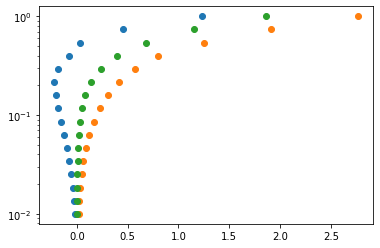

In [215]:
do_seed(0)
n_dim = 60
n_mrs = 16
n_pop = 101
x = torch.randn(n_pop, n_dim)
x = x/x.norm(dim=-1, keepdim=True)*5

mrs = torch.logspace(-2, 0, n_mrs)[:, None, None]
print(mrs.shape)

xmut = x+mrs*torch.randn(n_pop, n_dim)
x.shape, mrs.shape, xmut.shape

fit_diff = ackley(xmut)-ackley(x)
plt.scatter(fit_diff.min(dim=-1).values, mrs[:, 0, 0])
plt.scatter(fit_diff.max(dim=-1).values, mrs[:, 0, 0])
plt.scatter(fit_diff.mean(dim=-1), mrs[:, 0, 0])
plt.yscale('log')


In [192]:
print('Best MR for min of samples')
print(mrs[fit_diff.min(dim=-1).values.argmin(), 0, :])
print('Best MR for mean of samples')
print(mrs[fit_diff.mean(dim=-1).argmin(), 0, :])
print('Best MR for max of samples')
print(mrs[fit_diff.max(dim=-1).values.argmin(), 0, :])

Best MR for min of samples
tensor([0.2154])
Best MR for mean of samples
tensor([0.0100])
Best MR for max of samples
tensor([0.0100])


In [200]:
do_seed(0)
n_dim = 60
n_mrs = 1000
n_pop = 101
x = torch.randn(n_pop, n_dim)
x = x/x.norm(dim=-1, keepdim=True)*5

# mrs = torch.logspace(-2, 0, n_mrs)[:, None, :]
log_mr_low, log_mr_high = -2, 0
mrs = torch.rand(n_mrs, n_dim)*(log_mr_high-log_mr_low)+log_mr_low
mrs = 10**mrs
mrs = mrs[:, None, :]
print(mrs.shape)

xmut = x+mrs*torch.randn(n_pop, n_dim)
x.shape, mrs.shape, xmut.shape

fit_diff = ackley(xmut)-ackley(x)
# plt.plot(fit_diff.min(dim=-1).values, mrs[:, 0, 0])
# plt.plot(fit_diff.max(dim=-1).values, mrs[:, 0, 0])
# plt.plot(fit_diff.mean(dim=-1), mrs[:, 0, 0])
# plt.yscale('log')


torch.Size([1000, 1, 60])


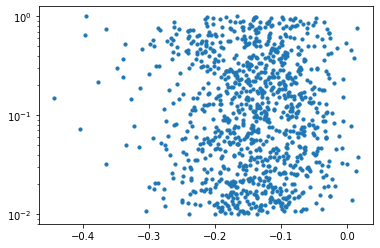

In [212]:
i=3
plt.scatter(fit_diff.min(dim=-1).values, mrs[:, 0, i], s=10)
plt.yscale('log')

Best MR for min of samples
tensor(0.0228)
tensor(0.3634)
tensor(0.9120)


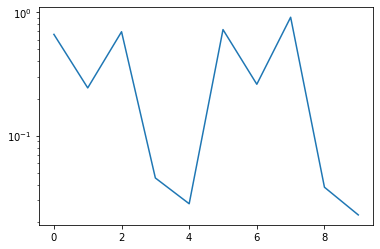

Best MR for mean of samples
tensor(0.0152)
tensor(0.1380)
tensor(0.5816)


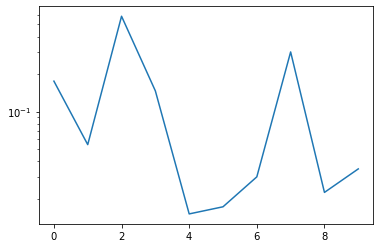

Best MR for max of samples
tensor(0.0180)
tensor(0.1372)
tensor(0.4915)


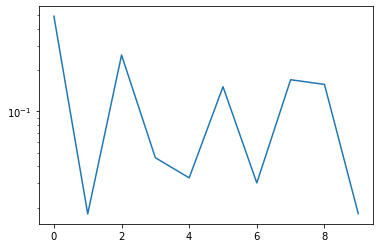

In [184]:
print('Best MR for min of samples')
print(mrs[fit_diff.min(dim=-1).values.argmin(), 0, :].min())
print(mrs[fit_diff.min(dim=-1).values.argmin(), 0, :].mean())
print(mrs[fit_diff.min(dim=-1).values.argmin(), 0, :].max())
plt.plot(mrs[fit_diff.min(dim=-1).values.argmin(), 0, :]); plt.yscale('log'); plt.show()
print('Best MR for mean of samples')
print(mrs[fit_diff.mean(dim=-1).argmin(), 0, :].min())
print(mrs[fit_diff.mean(dim=-1).argmin(), 0, :].mean())
print(mrs[fit_diff.mean(dim=-1).argmin(), 0, :].max())
plt.plot(mrs[fit_diff.mean(dim=-1).argmin(), 0, :]); plt.yscale('log'); plt.show()
print('Best MR for max of samples')
print(mrs[fit_diff.max(dim=-1).values.argmin(), 0, :].min())
print(mrs[fit_diff.max(dim=-1).values.argmin(), 0, :].mean())
print(mrs[fit_diff.max(dim=-1).values.argmin(), 0, :].max())
plt.plot(mrs[fit_diff.max(dim=-1).values.argmin(), 0, :]); plt.yscale('log'); plt.show()

torch.Size([16, 1, 1])


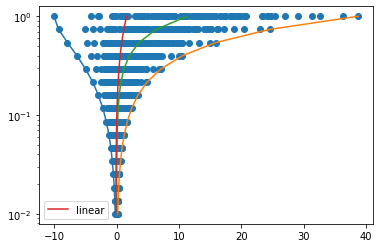

In [345]:
do_seed(0)
optim_fn = sphere
n_dim = 10
n_mrs = 16
n_pop = 101
x = torch.randn(n_pop, n_dim)
# x = x/x.norm(dim=-1, keepdim=True)*5

mrs = torch.logspace(-2, 0, n_mrs)[:, None, None]
print(mrs.shape)

xmut = x+mrs*torch.randn(n_pop, n_dim)
x.shape, mrs.shape, xmut.shape

fit_diff = optim_fn(xmut)-optim_fn(x)
plt.scatter(fit_diff.flatten(), mrs[:, 0].repeat(1, 101).flatten())
plt.plot(fit_diff.min(dim=-1).values, mrs[:, 0, 0])
plt.plot(fit_diff.max(dim=-1).values, mrs[:, 0, 0])
plt.plot(fit_diff.mean(dim=-1), mrs[:, 0, 0])

plt.plot(fit_diff_est, mrs[:, 0, 0], label='linear')
plt.yscale('log')
plt.legend()


(-0.1, 1.1)

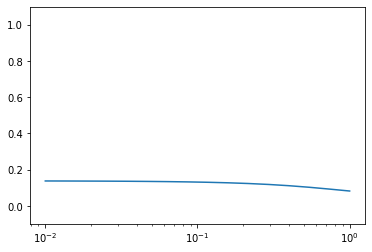

In [346]:
xdiff = xmut-x
xdiffnorm = xdiff.norm(dim=-1)
a = []
for i, mr in enumerate(mrs[:, 0, 0]):
    x_reg = xdiff[i, :, :].numpy()
    y_reg = fit_diff[i].numpy()
    linreg = LinearRegression().fit(x_reg, y_reg)
    y_reg_pred = linreg.predict(x_reg)
    a.append(linreg.score(x_reg, y_reg))
#     a.append(np.square(y_reg-y_reg_pred).mean())
plt.plot(mrs[:, 0, 0], a)
plt.xscale('log')
plt.ylim(-.1, 1.1)

In [371]:
def calc_ruggedness(optim_fn, x, mr=1e-2, steps=1000):
    xs = []
    for i in range(steps):
        xs.append(x)
        x = x+torch.randn_like(x)*mr
    xs = torch.stack(xs)
    fits = optim_fn(xs)
    left = fits[:-2]
    mid = fits[1:-1]
    right = fits[2:]
    
    dec = torch.logical_and(left>mid, mid>right)
    inc = torch.logical_and(left<mid, mid<right)
    smooth = torch.logical_or(dec, inc)
    ruggedness = 1-smooth.sum()/steps
    
    return ruggedness
        
print(calc_ruggedness(ackley, torch.randn(50), mr=1e+1))
print(calc_ruggedness(lin_fn, torch.randn(50), mr=1e+1))
print(calc_ruggedness(sphere, torch.randn(50), mr=1e+1))

tensor(0.6280)
tensor(0.5050)
tensor(0.4670)


In [273]:
# linreg = scipy.stats.linregress(mrs[:, 0].repeat(1, 101).flatten().numpy(), fit_diff.flatten().numpy())
# print(f'R^2 = {linreg.rvalue**2}')

R^2 = 0.8843266586629087


In [280]:
fit_diff.shape

torch.Size([16, 101])

In [296]:
from sklearn.linear_model import LinearRegression

LinearRegression()

In [242]:
import scipy.stats()